PDHG algorithm

In [55]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

In [56]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt

## Import data and add noise

### Fourier operator and noise

In [57]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data+0j*u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+s*np.random.randn(2*n*n).view(np.complex128)

### Operators

In [78]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
#linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")
linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [66]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.real(uk)).show()
pysap.Image(data = np.imag(uk)).show()

0.673407872449903


## Reconstruction

In [67]:
# Specific files import
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import f1,f2,g

In [88]:
param = {"pn1":2.15e-7,"epsilon":1e-5,"gamma":1e-10}

In [89]:
print(g(u0_mat,param["epsilon"]),f2(linear_op.op(u0_mat),param["pn1"],param["gamma"]))

1.9073479506915347e-11 1.7223146706819534e-07


In [90]:
# -- Solving --
# myconst = {"sigma":1.15,"tau":0.43}
uk,norms,energy,ssims = pdhg(y,p,fourier_op,linear_op,param,ground_truth=u0_mat,maxit=100)

10  iterations:
Cost: 1.7481780903177974e-07 
Norm: 0.23548478076046278 

20  iterations:
Cost: 1.6909880216879018e-07 
Norm: 0.026373436854244543 

30  iterations:
Cost: 1.6855816307148196e-07 
Norm: 0.011386016788385566 

40  iterations:
Cost: 1.6835821709806555e-07 
Norm: 0.006533027557513706 

50  iterations:
Cost: 1.6827565303571525e-07 
Norm: 0.0043876073892776144 

60  iterations:
Cost: 1.6822842604446378e-07 
Norm: 0.003238011567963298 

70  iterations:
Cost: 1.6819921892170444e-07 
Norm: 0.002521308413571435 

80  iterations:
Cost: 1.6817925082833096e-07 
Norm: 0.0020424307798314533 

90  iterations:
Cost: 1.6816503414244356e-07 
Norm: 0.0017115723441548131 

100  iterations:
Cost: 1.6815477257813096e-07 
Norm: 0.0014608801940299 

Finished in 130.46007084846497 seconds.


In [107]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.abs(uk)).show()

0.9336083416244443


In [105]:
pysap.Image(data = np.abs(uk-u0_mat)).show()

In [106]:
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

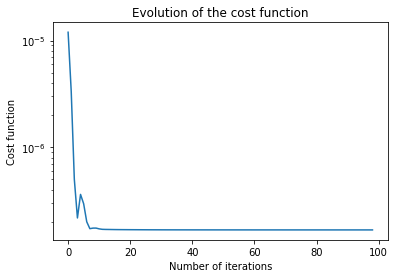

In [93]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/energy.png")
plt.show()

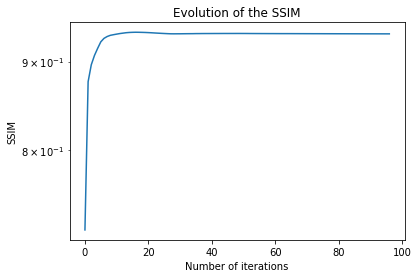

In [94]:
plt.plot(ssims[3:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/metrics.png")
plt.show()

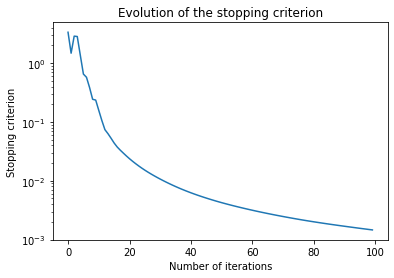

In [95]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Stopping criterion")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Comparisons/undecimated/pdhg/norms.png")
plt.show()

## Grid search over parameters

In [84]:
alphas = 1e-7*np.logspace(-1,1,7)
eps = 1e-5*np.logspace(-2,2,7)
ssims = np.zeros((7,7))
conv = np.zeros((7,7))
energies = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        param["pn1"]=alphas[i]
        param["epsilon"]=eps[j]
        uk,norms,energy = pdhg(y,p,fourier_op,linear_op,param,maxit=20,verbose=0)
        
        energies[i,j]=energy[-1]
        conv[i,j]=norms[-1]
        ssims[i,j]=ssim(uk,u0_mat)
        print(f"({alphas[i]},{eps[j]}):\nssim:{ssims[i,j]}\nenergy:{energies[i,j]}\nnorm:{conv[i,j]}\n")

Finished in 25.167152643203735 seconds.
(1e-08,1.0000000000000001e-07):
ssim:0.8661627958163691
energy:2.5532908119341067e-08
norm:0.36557219640430816

Finished in 25.217538118362427 seconds.
(1e-08,4.641588833612778e-07):
ssim:0.8762144566856367
energy:1.3144094836878048e-08
norm:0.18419326219191895

Finished in 25.312231302261353 seconds.
(1e-08,2.1544346900318835e-06):
ssim:0.8522913711523161
energy:9.742413542347966e-09
norm:0.10306588120537594

Finished in 25.651742935180664 seconds.
(1e-08,1e-05):
ssim:0.8377713501865329
energy:9.337881562341432e-09
norm:0.07825266153914823

Finished in 25.7410409450531 seconds.
(1e-08,4.641588833612778e-05):
ssim:0.800208238577764
energy:9.297923939822826e-09
norm:0.05902345837299917

Finished in 25.54370355606079 seconds.
(1e-08,0.00021544346900318823):
ssim:0.7578606953826112
energy:9.66703065941585e-09
norm:0.04626575823244466

Finished in 27.101019382476807 seconds.
(1e-08,0.001):
ssim:0.7248555422250937
energy:1.1215661039997475e-08
norm:0.

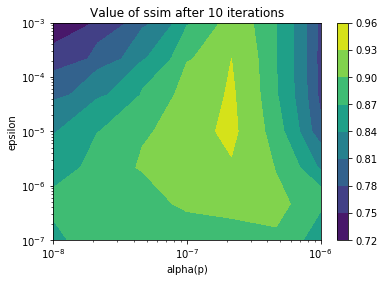

In [87]:
X,Y = np.meshgrid(alphas,eps)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims.transpose())
plt.title("Value of ssim after 10 iterations")
plt.xlabel("alpha(p)")
plt.ylabel("epsilon")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/undecimated/pdhg/ssims.png")
plt.show()

In [86]:
print(alphas[np.argmax(ssims)//7],eps[np.argmax(ssims)%7])

2.1544346900318832e-07 1e-05
